<h1> Time series prediction, end-to-end </h1>

This notebook illustrates several models to find the next value of a time-series:
<ol>
<li> Linear
<li> DNN
<li> CNN 
<li> RNN
</ol>

In [1]:
# change these to try this notebook out
BUCKET = 'cloud-training-demos-ml'
PROJECT = 'cloud-training-demos'
REGION = 'us-central1'
SEQ_LEN = 50

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['SEQ_LEN'] = str(SEQ_LEN)
os.environ['TFVERSION'] = '1.8'

In [4]:
import os
output = os.popen("gcloud config get-value project").readlines()
project_name = output[0][:-1]

# change these to try this notebook out
PROJECT = project_name
BUCKET = project_name
#BUCKET = BUCKET.replace("qwiklabs-gcp-", "inna-bckt-")
REGION = 'europe-west1'  ## note: Cloud ML Engine not availabe in europe-west3!

# set environment variables:
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

print(PROJECT)
print(BUCKET)
print(REGION)



qwiklabs-gcp-82dbf2cd13580b3b
qwiklabs-gcp-82dbf2cd13580b3b
europe-west1


<h3> Simulate some time-series data </h3>

Essentially a set of sinusoids with random amplitudes and frequencies.

In [5]:
import tensorflow as tf
print(tf.__version__)

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.8.0


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


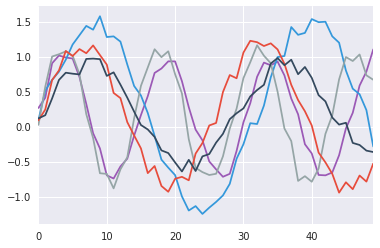

In [6]:
import numpy as np
import seaborn as sns

def create_time_series():
  freq = (np.random.random()*0.5) + 0.1  # 0.1 to 0.6
  ampl = np.random.random() + 0.5  # 0.5 to 1.5
  noise = [np.random.random()*0.3 for i in range(SEQ_LEN)] # -0.3 to +0.3 uniformly distributed
  x = np.sin(np.arange(0,SEQ_LEN) * freq) * ampl + noise
  return x

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i in range(0, 5):
  sns.tsplot( create_time_series(), color=flatui[i%len(flatui)] );  # 5 series

In [7]:
def to_csv(filename, N):
  with open(filename, 'w') as ofp:
    for lineno in range(0, N):
      seq = create_time_series()
      line = ",".join(map(str, seq))
      ofp.write(line + '\n')

import os
try:
  os.makedirs('data/sines/')
except OSError:
  pass
to_csv('data/sines/train-1.csv', 1000)  # 1000 sequences
to_csv('data/sines/valid-1.csv', 250)

In [9]:
!head -2 data/sines/*-1.csv

==> data/sines/train-1.csv <==
0.10514924639242763,0.7142912962480706,1.1825917512418638,1.5830470943218267,1.6779064667187797,1.263919010555403,0.933610294403417,0.495412273113492,-0.10593972366084445,-0.856395292228038,-1.1206386479156971,-1.3767407329638688,-1.1035065265235002,-0.9465282730869398,-0.4729505831786615,0.3318320142375057,0.6933131456691946,1.1231378919809611,1.6577920007637728,1.5923743694886556,1.2924527892301843,0.7978275899620257,0.25677363035063555,-0.25131480719186455,-0.814431565179768,-1.1016052583105818,-1.2754431770696835,-1.0573164362302399,-0.8915195861111692,-0.38846111932547545,0.21557808430165135,0.9421829717851188,1.2825519729957848,1.473130457221331,1.509883575842738,1.259611855839627,0.8761654138842536,0.4530248286387357,-0.3022866435396107,-0.7121393428515549,-1.1590991549761278,-1.3438342891438617,-1.1845946081522387,-0.7236414841132137,-0.2143144162145469,0.26684114895601885,0.7796747746764839,1.2762320727172844,1.4205235141437946,1.4166840306777937

<h3> Train model locally </h3>

Make sure the code works as intended.

The `model.py` and `task.py` containing the model code is in <a href="sinemodel">sinemodel/</a>

**Complete the TODOs in `model.py` before proceeding!**

Once you've completed the TODOs, set `--model` below to the appropriate model (linear,dnn,cnn,rnn,rnn2 or rnnN) and run it locally for a few steps to test the code.

In [21]:
%bash
DATADIR=$(pwd)/data/sines
OUTDIR=$(pwd)/trained/sines
rm -rf $OUTDIR
gcloud ml-engine local train \
   --module-name=sinemodel.task \
   --package-path=${PWD}/sinemodel \
   -- \
   --train_data_path="${DATADIR}/train-1.csv" \
   --eval_data_path="${DATADIR}/valid-1.csv"  \
   --output_dir=${OUTDIR} \
   --model=linear --train_steps=10 --sequence_length=$SEQ_LEN

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
INFO:tensorflow:TF_CONFIG environment variable: {'environment': 'cloud', 'job': {'job_name': 'sinemodel.task', 'args': ['--train_data_path=/content/datalab/gcp-ml-02-advanced-ml-with-tf-on-gcp/04-sequence-models-tensorflow-gcp/labs/data/sines/train-1.csv', '--eval_data_path=/content/datalab/gcp-ml-02-advanced-ml-with-tf-on-gcp/04-sequence-models-tensorflow-gcp/labs/data/sines/valid-1.csv', '--output_dir=/content/datalab/gcp-ml-02-advanced-ml-with-tf-on-gcp/04-sequence-models-tensorflow-gcp/labs/trained/sines', '--model=linear', '--train_steps=10', '--sequence_length=50']}, 'task': {}, 'cluster': {}}
INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_sav

<h3> Cloud ML Engine </h3>

Now to train on Cloud ML Engine with more data.

In [11]:
import shutil
shutil.rmtree('data/sines', ignore_errors=True)
os.makedirs('data/sines/')
for i in range(0,10):
  to_csv('data/sines/train-{}.csv'.format(i), 1000)  # 1000 sequences
  to_csv('data/sines/valid-{}.csv'.format(i), 250)

In [12]:
%bash
gsutil -m rm -rf gs://${BUCKET}/sines/*
gsutil -m cp data/sines/*.csv gs://${BUCKET}/sines

CommandException: 1 files/objects could not be removed.
Copying file://data/sines/train-0.csv [Content-Type=text/csv]...
Copying file://data/sines/train-1.csv [Content-Type=text/csv]...
Copying file://data/sines/train-2.csv [Content-Type=text/csv]...
Copying file://data/sines/train-3.csv [Content-Type=text/csv]...
Copying file://data/sines/train-4.csv [Content-Type=text/csv]...
Copying file://data/sines/train-5.csv [Content-Type=text/csv]...
Copying file://data/sines/train-6.csv [Content-Type=text/csv]...
Copying file://data/sines/train-7.csv [Content-Type=text/csv]...
Copying file://data/sines/train-8.csv [Content-Type=text/csv]...
Copying file://data/sines/train-9.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-0.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-1.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-2.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-3.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-4.

In [22]:
%%bash
#for MODEL in linear dnn cnn rnn rnn2 rnnN; do
for MODEL in linear rnnN; do
  OUTDIR=gs://${BUCKET}/sinewaves/${MODEL}
  JOBNAME=sines_${MODEL}_$(date -u +%y%m%d_%H%M%S)
  gsutil -m rm -rf $OUTDIR
  gcloud ml-engine jobs submit training $JOBNAME \
     --region=$REGION \
     --module-name=sinemodel.task \
     --package-path=${PWD}/sinemodel \
     --job-dir=$OUTDIR \
     --staging-bucket=gs://$BUCKET \
     --scale-tier=BASIC_GPU \
     --runtime-version=$TFVERSION \
     -- \
     --train_data_path="gs://${BUCKET}/sines/train*.csv" \
     --eval_data_path="gs://${BUCKET}/sines/valid*.csv"  \
     --output_dir=$OUTDIR \
     --train_steps=3000 --sequence_length=$SEQ_LEN --model=$MODEL
     --eval_delay_secs=10
     --min_eval_frequency=10
done

jobId: sines_linear_190228_091337
state: QUEUED
jobId: sines_rnnN_190228_091342
state: QUEUED


Removing gs://qwiklabs-gcp-82dbf2cd13580b3b/sinewaves/linear/#1551341472485863...
Removing gs://qwiklabs-gcp-82dbf2cd13580b3b/sinewaves/linear/checkpoint#1551341476039046...
Removing gs://qwiklabs-gcp-82dbf2cd13580b3b/sinewaves/linear/eval/#1551341280052868...
Removing gs://qwiklabs-gcp-82dbf2cd13580b3b/sinewaves/linear/eval/events.out.tfevents.1551341280.cmle-training-11435241258023410829#1551341482984142...
Removing gs://qwiklabs-gcp-82dbf2cd13580b3b/sinewaves/linear/events.out.tfevents.1551341252.cmle-training-11435241258023410829#1551341478413804...
Removing gs://qwiklabs-gcp-82dbf2cd13580b3b/sinewaves/linear/export/exporter/#1551341285012209...
Removing gs://qwiklabs-gcp-82dbf2cd13580b3b/sinewaves/linear/export/#1551341284612025...
Removing gs://qwiklabs-gcp-82dbf2cd13580b3b/sinewaves/linear/export/exporter/1551341282/#1551341294432487...
Removing gs://qwiklabs-gcp-82dbf2cd13580b3b/sinewaves/linear/export/exporter/1551341282/saved_model.pb#1551341294929999...
Removing gs://qwiklab

## Monitor training with TensorBoard

Use this cell to launch tensorboard. If tensorboard appears blank try refreshing after 5 minutes

In [24]:
from google.datalab.ml import TensorBoard
TensorBoard().start('gs://{}/sinewaves'.format(BUCKET))

TensorBoard was started successfully with pid 8169. Click here to access it.

8169

In [25]:
for pid in TensorBoard.list()['pid']:
  TensorBoard().stop(pid)
  print('Stopped TensorBoard with pid {}'.format(pid))

Stopped TensorBoard with pid 8169


## Results

Complete the below table with your own results! Then compare your results to the results in the solution notebook.

| Model  | Sequence length | # of steps | Training time | RMSE |
| ------ | --------------- | ---------- | -------       | ---- | 
| linear | 50              | 3000       | 13 mins 3 sec |    0.14642258 |
| dnn    | 50              | 3000       |             - |    - |
| cnn    | 50              | 3000       |             - |    - |
| rnn    | 50              | 3000       |             - |    - |
| rnn2   | 50              | 3000       |             - |    - |
| rnnN   | 50              | 3000       |             - |    - |

* Linear: Saving dict for global step 2939: RMSE = 0.14642258, RMSE_same_as_last = 0.30533966, global_step = 2939, loss = 0.021291882
* Linear: Saving dict for global step 3000: RMSE = 0.1525632, RMSE_same_as_last = 0.30533966, global_step = 3000, loss = 0.023260117

Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License